In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt

# What are SPDR Sector Funds?
SPDR Sector funds are Exchange-traded funds (ETFs) that divide the stocks that make up the S&P 500 into 11 sectors, e.g. real estate or communications. Instead of having to select and invest in individual companies from each sector to diversify their portfolio, investors can invest in these ETFs.

Naturally, using SPDR Sector Funds is just a rough measure of sector performance since it only contains a subset of stocks that are part of the S&500. A more accurate way would be to measure the returns for all publicly traded stocks belonging to an industry sector.

Here the list of SPDR Sector funds with their corresponding symbol:

- Communication Services (XLC)
- Consumer Discretionary (XLY)
- Consumer Staples (XLP)
- Energy (XLE)
- Financials (XLF)
- Health Care (XLV)
- Industrials (XLI)
- Materials (XLB)
- Real Estate (XLRE)
- Technology (XLK)
- Utilities (XLU).

In [2]:
Code2Name={
"XLC" : "Communication Services",
"XLY" : "Consumer Discretionary",
"XLP" : "Consumer Staples",
"XLE" : "Energy",
"XLF" : "Financials",
"XLV" : "Health Care",
"XLI" : "Industrials",
"XLB" : "Materials",
"XLRE" : "Real Estate",
"XLK" : "Technology",
"XLU" : "Utilities"
}

In [31]:
SPDR=yf.download(list(Code2Name.keys()))['Adj Close']

[*********************100%***********************]  11 of 11 completed


# Analysis

In [54]:
def plot(df,start=None):
    if start is None:
        start=df.index.min()
    recessions=DataReader('USREC', 'fred', start=start)['USREC']
    fig, ax = plt.subplots(figsize=(13, 9), dpi=300)
    
    if isinstance(df,pd.DataFrame):
        ylim = (df.min().min(),df.max().max())
    else:
        ylim = (df.min(),df.max())
    df.plot(ax=ax)
    ax.fill_between(recessions.index, ylim[0]-1e-2, ylim[1]+1e-2, recessions,facecolor='k', alpha=0.1)
    fig.legend
    return fig,ax

(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

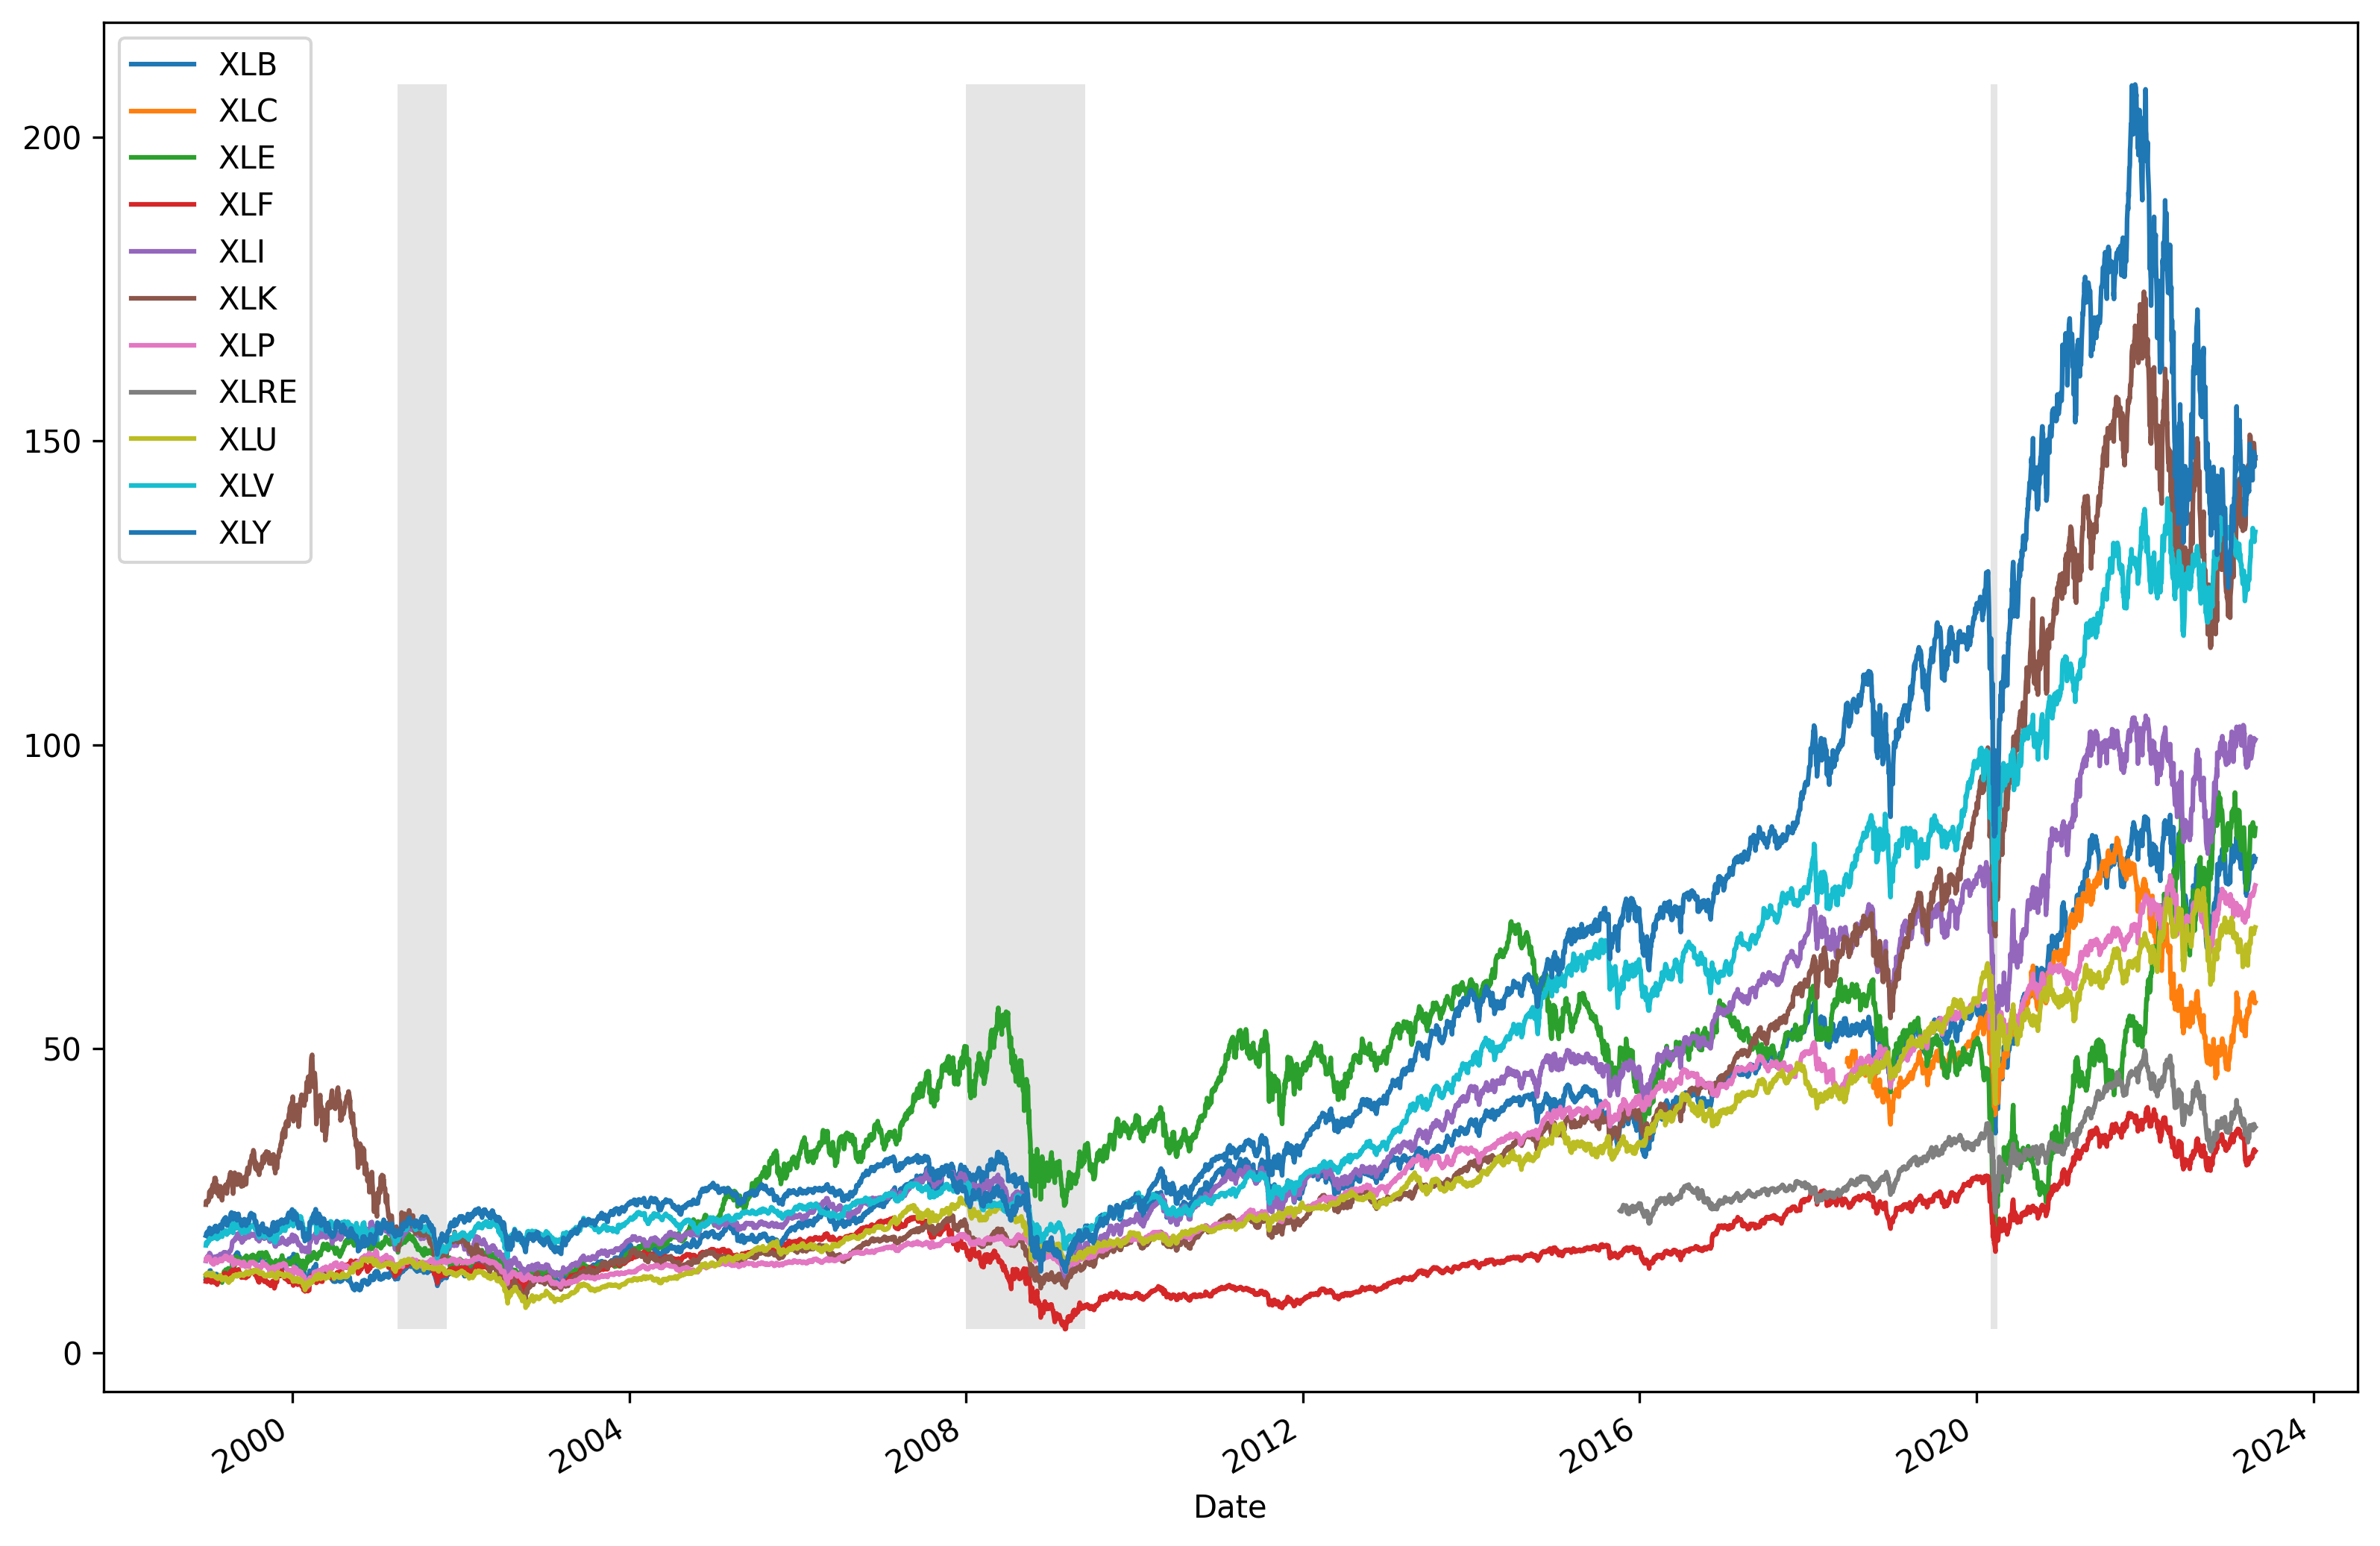

In [73]:
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
start="1999"
recessions=DataReader('USREC', 'fred', start=start)['USREC']
df=np.log1p(SPDR)
plot(SPDR)

In [65]:
recessions = DataReader('USRECQ', 'fred', start='1999').resample('QS').last()['USRECQ'].iloc[1:]
benchmark=yf.download("^GSPC")['Adj Close'] # SP500
benchmark

[*********************100%***********************]  1 of 1 completed


Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2023-04-18    4154.870117
2023-04-19    4154.520020
2023-04-20    4129.790039
2023-04-21    4133.520020
2023-04-24    4137.040039
Name: Adj Close, Length: 23942, dtype: float64

In [66]:
from dateutil.relativedelta import *

my_list=recessions.to_frame()
my_list=recessions.rolling(2).mean()
my_list=my_list[my_list==0.5]
 
recessions_start_end = []

for i in range(0, len(my_list), 2):
    recessions_start_end.append((my_list.index[i], my_list.index[i+1]))


In [67]:
def PeriodPerformance(df):
    return (df.iloc[-1]  / df.iloc[0]) -1
def MonthlyPerforamnce(df):
    return df.pct_change().resample('M').apply(lambda x: (x + 1).prod() - 1).mean()

In [68]:
stock_data=df
for start,end in recessions_start_end:
    selected_data = stock_data[(stock_data.index >= start) & (stock_data.index < end)]

In [69]:
recessions_start_end

[(Timestamp('2001-04-01 00:00:00'), Timestamp('2002-01-01 00:00:00')),
 (Timestamp('2008-01-01 00:00:00'), Timestamp('2009-07-01 00:00:00')),
 (Timestamp('2020-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))]

In [81]:
df_perforamce=pd.DataFrame(index=pd.MultiIndex.from_tuples([(None,None)],name=('Year','Metrics')),columns=['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV','XLY']).dropna()

for column in list(Code2Name.keys()):
    stock_data=SPDR.loc[:,column].copy()
    for start,end in recessions_start_end:
        selected_data = stock_data[((stock_data.index) >= start) & (stock_data.index < end)]
        selected_bench = benchmark[(benchmark.index >= start) & (benchmark.index < end)]
        
        # Calculate the performance of the stock during the selected period
        performance = PeriodPerformance(selected_data)
        bench_performance = PeriodPerformance(selected_bench)
        Monthly_avg_performance = MonthlyPerforamnce(selected_data)
        Monthly_avg_benchmark = MonthlyPerforamnce(selected_bench)
        df_perforamce.loc[(str(start.year),"Period Return (%)"),column]=performance*100
        df_perforamce.loc[(str(start.year),"Period Excess Return (%)"),column]=(performance-bench_performance)*100
        df_perforamce.loc[(str(start.year),"Average Monthly Return (%)"),column]=Monthly_avg_performance*100
        df_perforamce.loc[(str(start.year),"Monthly Excess Return (%)"),column]=(Monthly_avg_performance-Monthly_avg_benchmark)*100
df_perforamce.rename(columns=Code2Name,inplace=True)
df_perforamce

Materials Communication Services     Energy  \
Year Metrics                                                                   
2001 Period Return (%)            8.464928                    NaN -10.098124   
     Period Excess Return (%)     8.272064                    NaN -10.290987   
     Average Monthly Return (%)   1.146667                    0.0  -0.943755   
     Monthly Excess Return (%)     0.98295              -0.163718  -1.107472   
2008 Period Return (%)          -35.171975                    NaN -38.083593   
     Period Excess Return (%)     1.302224                    NaN  -1.609394   
     Average Monthly Return (%)  -1.931096                    0.0  -2.164838   
     Monthly Excess Return (%)    0.312051               2.243147   0.078309   
2020 Period Return (%)           -6.032639               0.076959 -35.303424   
     Period Excess Return (%)    -1.196319               4.913279 -30.467104   
     Average Monthly Return (%)   -0.55417               0.373832  -4.962803   
     Monthly Excess Return (%)   -0.076849               0.851153  -4.485482   

                                Financials Industrials Technology  \
Year Metrics                                                        
2001 Period Return (%)           -0.113115    5.593337  -0.826434   
     Period Excess Return (%)    -0.305978    5.400474  -1.019297   
     Average Monthly Return (%)   0.073484    0.917292   0.561612   
     Monthly Excess Return (%)   -0.090233    0.753575   0.397894   
2008 Period Return (%)          -55.421111  -40.620032 -28.773528   
     Period Excess Return (%)   -18.946912   -4.145833   7.700671   
     Average Monthly Return (%)  -3.462316    -2.42714  -1.565932   
     Monthly Excess Return (%)   -1.219169   -0.183993   0.677215   
2020 Period Return (%)          -24.436692  -16.226043  12.779832   
     Period Excess Return (%)   -19.600372  -11.389723  17.616152   
     Average Monthly Return (%)  -4.038024   -2.440253   2.343395   
     Monthly Excess Return (%)   -3.560703   -1.962932   2.820715   

                                Consumer Staples Real Estate  Utilities  \
Year Metrics                                                              
2001 Period Return (%)                  5.174211         NaN  -8.670523   
     Period Excess Return (%)           4.981348         NaN  -8.863387   
     Average Monthly Return (%)         0.598089         0.0   -0.95149   
     Monthly Excess Return (%)          0.434371   -0.163718  -1.115208   
2008 Period Return (%)                 -15.84335         NaN -29.761859   
     Period Excess Return (%)          20.630849         NaN    6.71234   
     Average Monthly Return (%)        -0.834911         0.0  -1.766406   
     Monthly Excess Return (%)          1.408236    2.243147   0.476741   
2020 Period Return (%)                 -4.872906   -7.533334  -9.934529   
     Period Excess Return (%)          -0.036586   -2.697014  -5.098208   
     Average Monthly Return (%)        -0.704675   -0.979546  -1.473515   
     Monthly Excess Return (%)         -0.227354   -0.502226  -0.996194   

                                Health Care Consumer Discretionary  
Year Metrics                                                        
2001 Period Return (%)             2.000909              10.318893  
     Period Excess Return (%)      1.808046              10.126029  
     Average Monthly Return (%)    0.487629               1.375395  
     Monthly Excess Return (%)     0.323911               1.211677  
2008 Period Return (%)           -22.333947             -26.459836  
     Period Excess Return (%)     14.140251              10.014362  
     Average Monthly Return (%)   -1.228099              -1.298115  
     Monthly Excess Return (%)     1.015048               0.945032  
2020 Period Return (%)            -1.124409               1.354162  
     Period Excess Return (%)      3.711911               6.190482  
     Average Monthly Return (%)    0.005358               0.787845

<Axes: ylabel='Year-Metrics'>

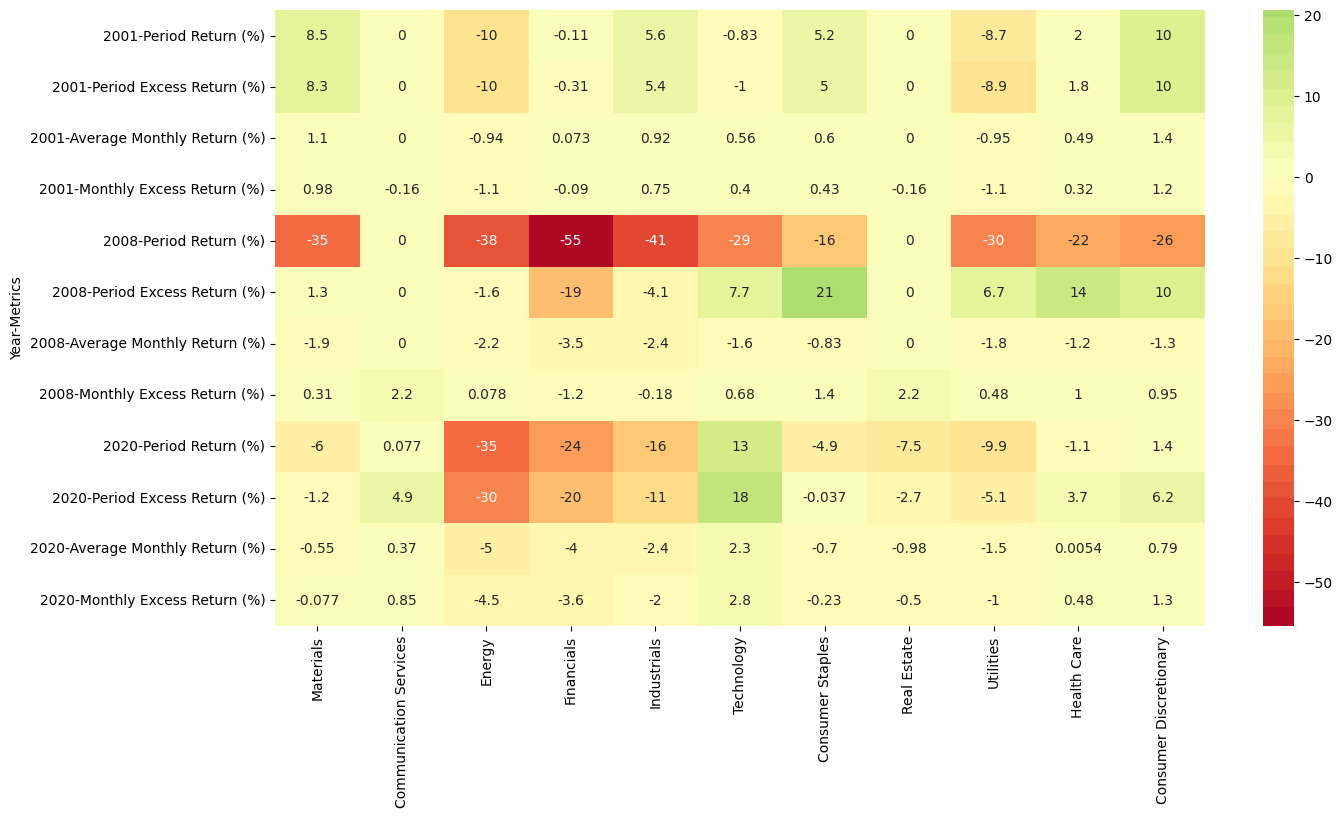

In [71]:
import seaborn as sns
palette = sns.color_palette("RdYlGn", 50)
plt.figure(figsize=(15,8))
sns.heatmap(df_perforamce.fillna(0),cmap=palette,center=0 , annot=True)

# Geting the actual data

In [104]:
import financedatabase as fd

In [105]:
equities = fd.Equities()
equities_united_states = equities.select(country="United States")


In [106]:
"TWTR" in equities_united_states.query('market=="NASDAQ Global Select"').index.to_list()

False

In [107]:
equities_united_states.head()

,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
A,"Agilent Technologies, Inc.","Agilent Technologies, Inc. provides applicatio...",USD,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,NYQ,New York Stock Exchange,United States,CA,Santa Clara,95051,http://www.agilent.com,Large Cap,US00846U1016,00846U101,BBG000C2V541,BBG000C2V3D6,BBG001SCTQY4
AA,Alcoa Corporation,"Alcoa Corporation, together with its subsidiar...",USD,Materials,Materials,Metals & Mining,NYQ,New York Stock Exchange,United States,PA,Pittsburgh,15212-5858,http://www.alcoa.com,Mid Cap,US0138721065,13872106,BBG00B3T3HK5,BBG00B3T3HD3,BBG00B3T3HF1
AABB,"Asia Broadband, Inc.","Asia Broadband Inc., through its subsidiary, A...",USD,Materials,Materials,Metals & Mining,PNK,OTC Bulletin Board,United States,NV,Las Vegas,89135,http://www.asiabroadbandinc.com,Micro Cap,NaN,NaN,NaN,NaN,NaN
AAC,Ares Acquisition Corporation,Ares Acquisition Corporation focuses on effect...,USD,Financials,Diversified Financials,Diversified Financial Services,NYQ,New York Stock Exchange,United States,NY,New York,10167,NaN,Small Cap,AU000000AAC9,NaN,NaN,NaN,NaN
AACI,Armada Acquisition Corp. I Common Stock,NaN,USD,Financials,Diversified Financials,Diversified Financial Services,NMS,NASDAQ Global Select,United States,NaN,NaN,NaN,NaN,Micro Cap,NaN,NaN,NaN,NaN,NaN


In [109]:
equities_united_states.reset_index().groupby(["sector"]).count()[['name']].sort_values('name')

,name
sector,
Utilities,190
Consumer Staples,425
Materials,441
Communication Services,479
Energy,496
Real Estate,545
Consumer Discretionary,795
Industrials,1101
Information Technology,1222


In [114]:
equities_united_states['industry_group'].nunique()

24

In [12]:
sectors=equities_united_states[["sector","industry_group","market"]].dropna().reset_index().set_index(['sector','industry_group','symbol']).sort_index().copy().T
sectors.columns.names=[None]*3
idx = pd.IndexSlice
sectors.loc[:,idx[:,:]]

Communication Services                                             \
        Media & Entertainment                                              
                         ADTR                AEMC                   AESE   
market     OTC Bulletin Board  OTC Bulletin Board  NASDAQ Capital Market   

                                                                         \
                                                                          
                      AFTM                      AMC                AMLH   
market  OTC Bulletin Board  New York Stock Exchange  OTC Bulletin Board   

                                                                           \
                                                                            
                      ATIG                  ATVI                      AUD   
market  OTC Bulletin Board  NASDAQ Global Select  New York Stock Exchange   

                              ...                Utilities  \
                              ...                Utilities   
                        AVID  ...                      VST   
market  NASDAQ Global Select  ...  New York Stock Exchange   

                                                       \
                                                        
                        VST-WTA                  VWTR   
market  New York Stock Exchange  NASDAQ Global Select   

                                                                              \
                                                                               
                            WEC                WGEI                     WTRG   
market  New York Stock Exchange  OTC Bulletin Board  New York Stock Exchange   

                                                                      \
                                                                       
                         XEL                XGEN               XGEND   
market  NASDAQ Global Select  OTC Bulletin Board  OTC Bulletin Board   

                              
                              
                        YORW  
market  NASDAQ Global Select  

[1 rows x 10751 columns]

\begin{align}
sector\_ index_{t} =\sum _{i}\frac{{}^iMC_{t}}{\sum _{j} {}^jMC_{t}} {}^iP_{t}
\end{align}


 Lets apply this to the Utilities sector data

## Utililities

In [115]:
Util=pd.read_csv(r'Data\Scraped MarketCap\Utilities.csv',header=[0,1],index_col=0)

In [116]:
df=Util.iloc[0:2,0:6].copy()
df

,NFE,VST,MMMW,IRCC,DUK,BKH
,Market Cap,Market Cap,Market Cap,Market Cap,Market Cap,Market Cap
Date,,,,,,
1984-04-02,NaN,NaN,NaN,NaN,1.399000e+09,90930000.0
1984-04-03,NaN,NaN,NaN,NaN,1.384000e+09,92010000.0
